# Анализ А/Б теста для Дункан МаКлауд

## Условия и задачи:

**Запущены два лендинга, с разной степенью подробности описания платформы. A- короткий и яркий и B - подробный.**  
**Определить: имеются ли различия в поведении пользователей вошедших с разных типов лендинга по показателям юнит-экономики**

Имортируем необходимые библиотеки и читаем полученные данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from datetime import datetime

In [2]:
ab_test=pd.read_csv('ab_test_cookies.csv')

In [3]:
ab_test.head()

,cookie_id,grp
0,65hj0vyf6kfrckx,A
1,dnjw8oy95td2jqf,B
2,beiyb0xfie92m43,B
3,xyd746tr80pnnbi,B
4,dpq6rqi93zgekgv,A


In [4]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253172 entries, 0 to 253171
Data columns (total 2 columns):
cookie_id    253172 non-null object
grp          253172 non-null object
dtypes: object(2)
memory usage: 3.9+ MB


In [5]:
registration=pd.read_csv('registrations_in_test_period.csv')
registration.head()

,cookie_id,user_id
0,NaN,382603
1,NaN,295154
2,NaN,999732
3,NaN,16486
4,NaN,678352


In [6]:
registration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172350 entries, 0 to 172349
Data columns (total 2 columns):
cookie_id    72485 non-null object
user_id      172350 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.6+ MB


Объединим датафрейм с показателячми лендинга с датафреймом регистраций

In [7]:
reg_landing=ab_test.merge(registration,on='cookie_id', how='left')
reg_landing


,cookie_id,grp,user_id
0,65hj0vyf6kfrckx,A,716849.0
1,dnjw8oy95td2jqf,B,NaN
2,beiyb0xfie92m43,B,NaN
3,xyd746tr80pnnbi,B,NaN
4,dpq6rqi93zgekgv,A,NaN
...,...,...,...
253167,e2e7xo4mh9gbqpb,A,334362.0
253168,cmwfr9djxdj6vgr,B,NaN
253169,0ou6tl9qdzq9w4x,B,NaN
253170,c375picbbkkzfy9,B,NaN


Создаем датафрейм с покупателями

In [8]:
purchase=pd.read_csv('purchases_in_test_period.csv')
purchase.head()

,purchase_id,user_id,amount
0,1,275851,350
1,2,923077,1500
2,3,959409,50
3,4,692022,350
4,5,737918,50


In [9]:
purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35147 entries, 0 to 35146
Data columns (total 3 columns):
purchase_id    35147 non-null int64
user_id        35147 non-null int64
amount         35147 non-null int64
dtypes: int64(3)
memory usage: 823.9 KB


Группируем по User_id

In [10]:
purchase_group=purchase.groupby('user_id', as_index='False').agg({'amount':'sum'})
purchase_group

,amount
user_id,
0,350
27,700
33,350
61,50
76,1500
...,...
999817,50
999837,350
999877,350


объединяем полученный датафрейм с данными по регистрациям и лендингу

In [11]:
ab_total=reg_landing.merge(purchase_group, on='user_id', how='left')
ab_total

,cookie_id,grp,user_id,amount
0,65hj0vyf6kfrckx,A,716849.0,NaN
1,dnjw8oy95td2jqf,B,NaN,NaN
2,beiyb0xfie92m43,B,NaN,NaN
3,xyd746tr80pnnbi,B,NaN,NaN
4,dpq6rqi93zgekgv,A,NaN,NaN
...,...,...,...,...
253167,e2e7xo4mh9gbqpb,A,334362.0,NaN
253168,cmwfr9djxdj6vgr,B,NaN,NaN
253169,0ou6tl9qdzq9w4x,B,NaN,NaN
253170,c375picbbkkzfy9,B,NaN,NaN


Теперь считаем агрегированные данные по групам

In [12]:
ab_summary=ab_total.groupby('grp').agg({'user_id':'count','amount':'count'})
ab_summary

,user_id,amount
grp,,
A,31439,5815
B,41046,8797


И конверсию для каждой из групп

In [13]:
ab_summary['conversion']=ab_summary.amount/ab_summary.user_id
ab_summary

,user_id,amount,conversion
grp,,,
A,31439,5815,0.184961
B,41046,8797,0.214321


затем рассчитываем средний чек, выручку, ARPU, и дополнительную выручку

In [14]:
ab_summary=ab_summary.merge(ab_total.groupby('grp').agg({'amount':'mean'}).rename(columns={'amount':'avg_bill'}),left_index=True,right_index=True)

In [15]:
ab_summary

,user_id,amount,conversion,avg_bill
grp,,,,
A,31439,5815,0.184961,553.052451
B,41046,8797,0.214321,623.093100


In [16]:
ab_summary=ab_summary.merge(ab_total.groupby('grp').agg({'amount':'sum'}).rename(columns={'amount':'revenue'}),left_index=True,right_index=True)

In [17]:
ab_summary['ARPU']=ab_summary.revenue/ab_summary.user_id
ab_summary['ad_revenue']=ab_summary.user_id*(ab_summary.ARPU-ab_summary.loc['A','ARPU'])
ab_summary.rename(columns={'user_id':'users_count','amount':'buyers_count'},inplace=True)
ab_summary

,users_count,buyers_count,conversion,avg_bill,revenue,ARPU,ad_revenue
grp,,,,,,,
A,31439,5815,0.184961,553.052451,3216000.0,102.293330,0.000000e+00
B,41046,8797,0.214321,623.093100,5481350.0,133.541636,1.282618e+06


рассчитаем значимость изменения конверсии.

In [18]:
ztest(ab_total.loc[ab_total.grp=='A','amount'].apply(lambda x: 1 if pd.notnull(x) else 0), ab_total.loc[ab_total.grp=='B','amount'].apply(lambda x: 1 if pd.notnull(x) else 0))

(-0.5787826665981052, 0.5627358282855696)

Поскольку p_value, достаточно велико, то мы не можем говорить о значимом увеличении конверсии.

Считаем изменения среднего чека 

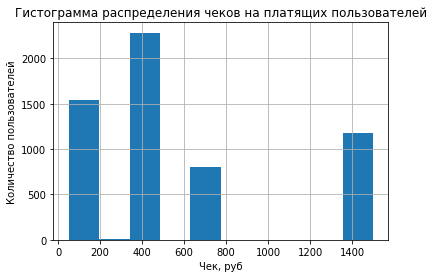

Shapiro-Wilk p-value is 0.0


C:\Users\Oleg\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [19]:
ax = plt.subplot()
ab_total.loc[ab_total.grp=='A','amount'].dropna().hist()
ax.set_xlabel('Чек, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения чеков на платящих пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_total.loc[ab_total.grp == 'A', 'amount'].dropna())[1])


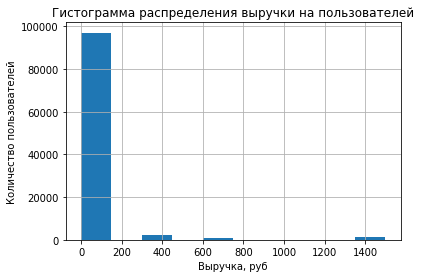

Shapiro-Wilk p-value is 0.0


In [20]:
ax = plt.subplot()
ab_total.loc[ab_total.grp=='A','amount'].fillna(0).hist()
ax.set_xlabel('Выручка, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения выручки на пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_total.loc[ab_total.grp == 'A', 'amount'].fillna(0))[1])

Как показывает тест Шапиро_Уилка распределения среднего чека и покупок ненормальные

Сравним средние чеки:

In [21]:
print(stats.mannwhitneyu(ab_total.loc[ab_total.grp == 'A', 'amount'].dropna(), ab_total.loc[ab_total.grp == 'B', 'amount'].dropna()),
stats.ttest_ind(ab_total.loc[ab_total.grp == 'A', 'amount'].dropna(), ab_total.loc[ab_total.grp == 'B', 'amount'].dropna())
      , sep = '\n')

MannwhitneyuResult(statistic=23997449.0, pvalue=1.5894355470534353e-11)
Ttest_indResult(statistic=-7.698737457881192, pvalue=1.4620086805787972e-14)


Поскольку, распределение средних чеков и APRU ненормально, то для определения статической значимости разницы между группами применяем  тест Манна-Уитни и Т тест.
Оба теста показывают значимые отклонения. Значит мы можем утвеждать, что гипотеза о равентстве среднего чека в группах теста  может быть отвергнута.


Сравниваем ARPU

In [22]:
print(stats.mannwhitneyu(ab_total.loc[ab_total.grp == 'A', 'amount'].fillna(0), ab_total.loc[ab_total.grp == 'B', 'amount'].fillna(0)),
stats.ttest_ind(ab_total.loc[ab_total.grp == 'A', 'amount'].fillna(0), ab_total.loc[ab_total.grp == 'B', 'amount'].fillna(0))
      , sep = '\n')

MannwhitneyuResult(statistic=7687257761.0, pvalue=0.2131782418227564)
Ttest_indResult(statistic=-5.6615374023743055, pvalue=1.501844531390091e-08)


Т-тест показывает, что средние распределений различаются и APRU в группе B статистически значимо увеличилось.

Определяем доверительные интервалы:

In [23]:
def get_conf_interval(data, conf_level = 0.95):  
        buf = (stats.t.interval(conf_level, len(data),
                             loc=np.mean(data), scale=stats.sem(data)))
        return (buf[1] - buf[0])/2
    
def get_conf_interval_z(succ, tot):  
    buf = proportion_confint(succ, tot)
    return buf[1] - buf[0]

In [24]:
get_conf_interval(ab_total.loc[ab_total.grp == 'A', 'amount'].fillna(0))

1.0981455326877274

In [25]:
# Составляем словарь с доверительными интервалами для каждой метрики и для каждой группы
conf_intervals = {'ARPU':{'A':get_conf_interval(ab_total.loc[ab_total.grp == 'A', 'amount'].fillna(0)),
                          'B':get_conf_interval(ab_total.loc[ab_total.grp == 'B', 'amount'].fillna(0))},
                  'conversion':{'A':get_conf_interval_z(ab_total.loc[ab_total.grp == 'A', 'amount'].dropna().count(),
                                                        ab_total.loc[ab_total.grp == 'A', 'user_id'].count()),
                               'B':get_conf_interval_z(ab_total.loc[ab_total.grp == 'B', 'amount'].dropna().count(),
                                                        ab_total.loc[ab_total.grp == 'B', 'user_id'].count())},
                  'avg_bill':{'A':get_conf_interval(ab_total.loc[ab_total.grp == 'A', 'amount'].dropna()),
                          'B':get_conf_interval(ab_total.loc[ab_total.grp == 'B', 'amount'].dropna())}
                 }

основные метрики А/Б

In [26]:
conf_intervals

{'ARPU': {'A': 1.0981455326877274, 'B': 0.9918432756035216},
 'conversion': {'A': 0.008583676140727192, 'B': 0.00793957485423974},
 'avg_bill': {'A': 13.259018604526204, 'B': 11.55088606505592}}

In [27]:
# функция для подстановки подписей на barplot
def set_labels(axes):  
    y0, y1 = axes.get_ybound()  
    y_shift = 0.15* (y1 - y0)  


    for i, rect in enumerate(axes.patches):  
        height = rect.get_height()
        if abs(height) <= 10000:
            label = str(round(height, 2))
            if label[-1] == '0':
                label = label[:-1]
        elif abs(height) <= 1000000:
            label = str(round(height/1000, 1))
            if label[-1] == '0':
                label = label[:-1] + 'k'
            else:
                label = label + 'k'
        else:
            label = str(round(height/1000000, 2))
            if label[-1] == '0':
                label = label[:-1] + 'm'
            else:
                label = label + 'm'
        x = rect.get_x() + rect.get_width() / 2  
        y = height + y_shift * 0.8  
        if height < 0:
            y = y_shift * 0.8 
        axes.text(x, y, label, ha='center', va='center', alpha = 0.7)
        axes.set_ybound(y0, y1 + 1.5*y_shift)

In [28]:
plot_summary = ab_summary.T 
# Транспонированная таблица 
significant_changes = ['conversion', 'avg_bill'] 
# Метрики со статзначимыми различиями

In [29]:
ab_summary.T

grp,A,B
users_count,3.143900e+04,4.104600e+04
buyers_count,5.815000e+03,8.797000e+03
conversion,1.849614e-01,2.143205e-01
avg_bill,5.530525e+02,6.230931e+02
revenue,3.216000e+06,5.481350e+06
ARPU,1.022933e+02,1.335416e+02
ad_revenue,0.000000e+00,1.282618e+06


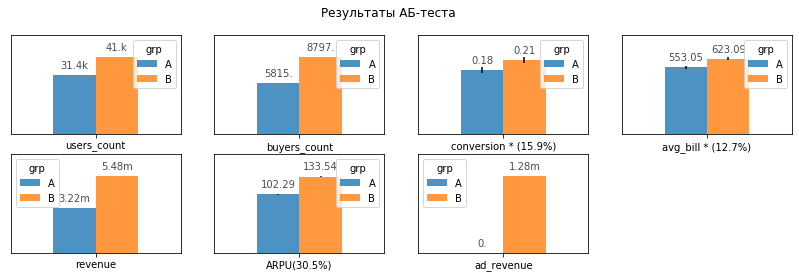

In [30]:
from matplotlib import gridspec
from math import ceil

ax = [] 
n_pict_in_line = 4 

gs = gridspec.GridSpec(ceil(len(plot_summary) / float(n_pict_in_line)), n_pict_in_line) 
# Создаём сетку для графиков
fig = plt.figure(figsize=(n_pict_in_line*3 + 2,
                          ceil(len(plot_summary) / n_pict_in_line) * 2))

## Считаем изменение метрики в процентах
delta_percent={}
for row in plot_summary.index:  
    if 'users_count' != row and 'buyers_count' != row and 'revenue' != row and "ad_revenue" != row:
        delta_percent[row] = '(' + str(round(plot_summary.loc[row, :].max()/\
                                  plot_summary.loc[row, :].min()*100 - 100, 1)) + '%)'
        
fig.suptitle('Результаты АБ-теста')

## Строим графики
for i, col in enumerate(plot_summary.index):
    ax.append(plt.subplot(gs[i // n_pict_in_line, i % n_pict_in_line])) 
    plot_summary.loc[[col], :].plot(kind='bar', rot=0, ax=ax[i], alpha=0.8, 
                                   yerr=conf_intervals[col] if col in conf_intervals else 0) 
    
    
    stars = ' * ' if col in significant_changes else '' 
    ticks = ax[-1].get_xticklabels()
    ticks[0] = col + stars + delta_percent[col] if col in delta_percent else col + stars
    ax[-1].set_xticklabels(ticks)
    ax[-1].set_yticks([])
    set_labels(axes=ax[i])

## Выводы:

1. Конверсия выросла незначительно 15,9%
2. Средний чек также увеличился незначительно 12,7%
3. ARPU увеличился значительно на 30,5%

Более подробный лендинг (B) опережает менее информативный лендинг (A) по всем показателям, с разной степенью значимости. Наиболее явное преимущество прослеживается в ARPU - 30,5%, а так же в общей выручке, что соответственно приводит к генерации дополнительной выручки в размере 1,28 млн. Так же стоит отметить, что лендинг B привлекает больше пользователей в абсолютном выражении.   
**Рекомендации: запустить тест на большее время и большую аудиторию. Если преимущества останутся устойчивыми, то следует применять лендинг 'B'.**
    